# Thesis: Training an Adapter for Cruise

This notebook documents the workflow for training a YOLO-based adapter model tailored for cruise applications. The process includes dataset preparation, configuration file creation, model training, and result management.

## Install Required Libraries

In this step, we will install the necessary libraries for training and evaluation. This includes the `ultralytics` package, which provides the YOLO implementation used in this workflow.

In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00:00:0100:01


In [2]:
from ultralytics import YOLO
import os
import cv2
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import shutil
import random
warnings.filterwarnings("ignore", category=RuntimeWarning)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Copy dataset from dataset save with kaggle

In [3]:
!cp -r /kaggle/input/adapter-cruise-control dataset

## Create YAML Configuration for Training

This section describes how to automatically generate a `data.yaml` configuration file required for YOLO training. The script reads class names from `classes.txt`, sets up dataset paths, and writes the configuration in YAML format.

In [4]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': 'dataset',
      'train': 'train/images',
      'val': 'valid/images',
      'test': 'test/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = 'dataset/classes.txt'
path_to_data_yaml = 'data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat data.yaml

Created config file at data.yaml

File contents:

path: dataset
train: train/images
val: valid/images
test: test/images
nc: 19
names:
- person
- bicycle
- car
- motorcycle
- bus
- truck
- other-vehicle
- traffic light
- stop sign
- Speed limit 20km-h
- Speed limit 30km-h
- Speed limit 40km-h
- Speed limit 50km-h
- Speed limit 60km-h
- Speed limit 70km-h
- Speed limit 80km-h
- Speed limit 100km-h
- Speed limit 120km-h
- End of speed limit 80km-h


# Data Visualization

This section demonstrates how to visualize the training data with bounding boxes. The code will:

1. Load a random image from the training dataset
2. Read its corresponding label file
3. Draw bounding boxes and class labels on the image
4. Display the annotated image using matplotlib

This visualization helps verify that:
- Images are loading correctly
- Label files are properly formatted
- Bounding box coordinates are accurate
- Class IDs are valid

The visualization uses:
- OpenCV for image processing and drawing
- Matplotlib for display
- Green bounding boxes with class labels
- RGB color format for proper display

You can run the next cell to see a random training example with its annotations.


In [5]:
def load_classes(classes_path):
    """
    Load class names from classes.txt file.
    
    Args:
        classes_path (str): Path to the classes.txt file
    
    Returns:
        list: List of class names
    """
    if not os.path.exists(classes_path):
        print(f"Classes file {classes_path} not found!")
        return []
    
    with open(classes_path, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [6]:
def visualize_random_samples(data_path, num_samples=6):
    """
    Visualize random samples from the dataset with bounding boxes in a 2x3 subplot.

    Args:
        data_path (str): Path to the dataset directory
        num_samples (int): Number of random samples to visualize (default=6 for 2x3 grid)
    """
    # Load class names
    classes_path = os.path.join(data_path, 'classes.txt')
    class_names = load_classes(classes_path)
    if not class_names:
        print("No class names loaded, using default class IDs.")
    
    # Load the images and labels
    images_path = os.path.join(data_path, 'train', 'images')
    labels_path = os.path.join(data_path, 'train', 'labels')

    # Get list of image files
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random images
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Create a 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the 2x3 array for easier iteration

    for idx, random_image in enumerate(selected_images):
        image_path = os.path.join(images_path, random_image)
        label_path = os.path.join(labels_path, random_image.replace('.jpg', '.txt')
                                 .replace('.jpeg', '.txt').replace('.png', '.txt'))

        # Read and process the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Read labels and draw boxes
        num_objects = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            height, width = img.shape[:2]
            for line in lines:
                class_id, x_center, y_center, w, h = map(float, line.strip().split())
                class_id = int(class_id)
                
                # Get class name or fallback to class ID
                class_label = class_names[class_id] if class_id < len(class_names) else f'Class {class_id}'

                # Convert normalized coordinates to pixel coordinates
                x1 = int((x_center - w/2) * width)
                y1 = int((y_center - h/2) * height)
                x2 = int((x_center + w/2) * width)
                y2 = int((y_center + h/2) * height)

                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Add class label
                cv2.putText(img, class_label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                num_objects += 1

        # Display image in subplot
        axes[idx].imshow(img)
        axes[idx].set_title(f'Image: {random_image}\nObjects: {num_objects}')
        axes[idx].axis('off')

        # Print image details
        print(f'Image {idx+1}:')
        print(f'Image shape: {img.shape}')
        print(f'Image path: {image_path}')
        print(f'Number of objects detected: {num_objects}\n')

    # Hide empty subplots if fewer images than num_samples
    for idx in range(len(selected_images), 6):
        axes[idx].axis('off')
        axes[idx].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Image 1:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/frame_002661_jpg.rf.d091cb8d38a9ce24c37b4aeaf86f5ad4.jpg
Number of objects detected: 3

Image 2:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/frame_002630_jpg.rf.c40c6fe96df3f821c4167c86b4f5fc01.jpg
Number of objects detected: 4

Image 3:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/frame_001618_jpg.rf.d8b44250e32c1a6163abdd5306026c78.jpg
Number of objects detected: 2

Image 4:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/00095_jpg.rf.9f3921157ffa6a7957220a640a4ea0ee.jpg
Number of objects detected: 2

Image 5:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/IMG_1081_Adib-0280_jpg.rf.71877a2ca0cb38094340d51eaa65cfe0.jpg
Number of objects detected: 4

Image 6:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/0644_jpg.rf.a655845701d296d07153b448c0edf5ca.jpg
Number of objects detected: 3



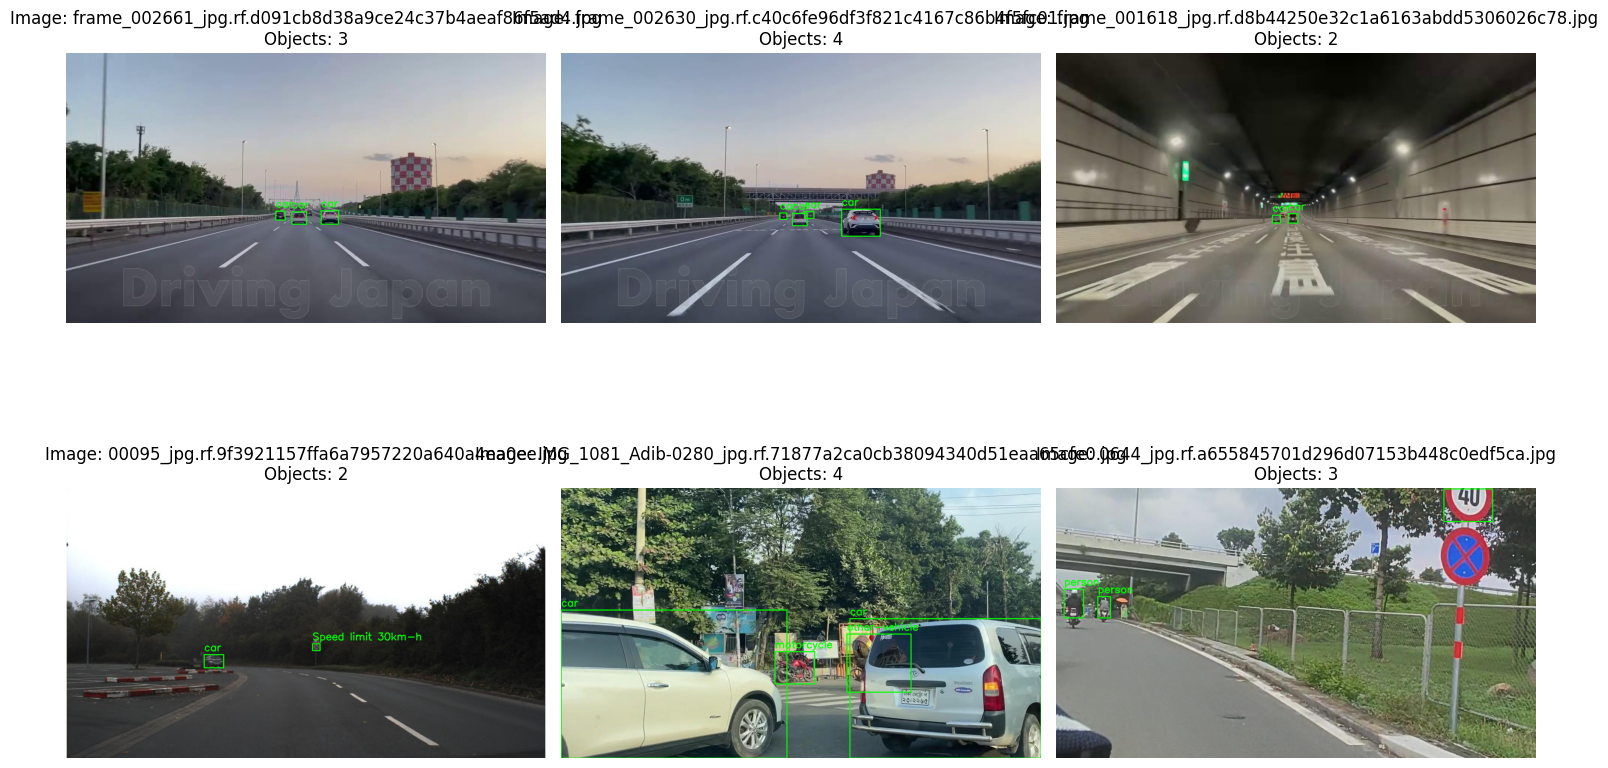

In [7]:
data_path = 'dataset'
visualize_random_samples(data_path, num_samples=6)

## Start YOLO model training

The model and training parameters are defined in the cell below.
Please run the next cell to begin training.

In [8]:
# Load pretrained model (better starting point than from scratch)
model = YOLO("yolo11n.pt")  # or "yolo11n.pt" for standard YOLOv11

100%|██████████| 5.35M/5.35M [00:00<00:00, 68.4MB/s]


In [9]:
# Train the model with optimized parameters
model.train(
    data="data.yaml",       # Path to dataset config file
    epochs=100,             # Number of training epochs
    imgsz=640,              # Input image size (square: 640x640)
    batch=16,               # Batch size (adjust based on GPU memory)
    device=[0, 1],          # Use GPU 0 and GPU 1
    patience=50,            # Stop early if no improvement in 30 epochs
    optimizer="auto",       # Let YOLO choose the best optimizer
        lr0=0.005                # Initial learning rate
)

Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

100%|██████████| 755k/755k [00:00<00:00, 17.3MB/s]


Overriding model.yaml nc=80 with nc=19

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/dataset/train/labels... 4157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4157/4157 [00:03<00:00, 1172.02it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 426.7±72.5 MB/s, size: 75.8 KB)


val: Scanning /kaggle/working/dataset/valid/labels... 1041 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1041/1041 [00:00<00:00, 1397.21it/s]


val: New cache created: /kaggle/working/dataset/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.3G      1.177      2.898      1.013         51        640: 100%|██████████| 260/260 [00:59<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:08<00:00,  7.74it/s]


                   all       1041       6040      0.679      0.158      0.181      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.32G      1.012      1.417      0.988         58        640: 100%|██████████| 260/260 [00:55<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.18it/s]


                   all       1041       6040      0.672      0.213      0.228      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.39G      0.967      1.216     0.9826         59        640: 100%|██████████| 260/260 [00:55<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.15it/s]


                   all       1041       6040      0.482      0.246      0.264      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       1.4G     0.9624      1.106     0.9802         77        640: 100%|██████████| 260/260 [00:54<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.20it/s]


                   all       1041       6040      0.495      0.265      0.293        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.42G     0.9236      1.016     0.9682         84        640: 100%|██████████| 260/260 [00:55<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.02it/s]


                   all       1041       6040      0.557      0.262      0.301      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.43G     0.9049     0.9415     0.9606         77        640: 100%|██████████| 260/260 [00:54<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.14it/s]


                   all       1041       6040      0.445      0.349      0.353      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.51G     0.9016     0.9058     0.9637         91        640: 100%|██████████| 260/260 [00:55<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.58it/s]


                   all       1041       6040      0.443      0.321      0.358      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.52G      0.881     0.8575     0.9525         74        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.94it/s]


                   all       1041       6040      0.686      0.273      0.346      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.54G     0.8827     0.8402     0.9526         93        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.80it/s]


                   all       1041       6040        0.3      0.396      0.343      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.55G     0.8711     0.8058     0.9546         86        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.74it/s]


                   all       1041       6040      0.374      0.379      0.361      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.57G     0.8637     0.7901     0.9494         44        640: 100%|██████████| 260/260 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.97it/s]


                   all       1041       6040       0.35      0.395      0.369      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.58G     0.8537     0.7741     0.9433        105        640: 100%|██████████| 260/260 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.29it/s]


                   all       1041       6040      0.355      0.411      0.376      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       1.6G     0.8664     0.7756     0.9534         97        640: 100%|██████████| 260/260 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.28it/s]


                   all       1041       6040      0.352      0.391      0.382      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.61G     0.8533     0.7571      0.947         85        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.19it/s]


                   all       1041       6040      0.361      0.416      0.394      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.63G     0.8402     0.7403     0.9418         77        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.06it/s]


                   all       1041       6040       0.42      0.414      0.387      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.64G     0.8291     0.7195      0.937         66        640: 100%|██████████| 260/260 [00:55<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.14it/s]


                   all       1041       6040      0.353      0.423      0.392      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.66G     0.8201     0.7217     0.9342         48        640: 100%|██████████| 260/260 [00:55<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.14it/s]


                   all       1041       6040      0.423      0.403      0.411      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.67G     0.8252     0.7206     0.9369        110        640: 100%|██████████| 260/260 [00:53<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.07it/s]


                   all       1041       6040       0.34      0.427      0.386      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.69G     0.8048     0.6924     0.9252         59        640: 100%|██████████| 260/260 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.22it/s]


                   all       1041       6040      0.402      0.407      0.407      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       1.7G     0.8141     0.6945     0.9357         72        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.77it/s]


                   all       1041       6040      0.568      0.351      0.394      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.72G      0.817     0.6891     0.9341         76        640: 100%|██████████| 260/260 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.48it/s]


                   all       1041       6040      0.411      0.446      0.424      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.73G     0.7908      0.678     0.9246         34        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.17it/s]


                   all       1041       6040      0.429       0.35      0.396      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.75G     0.8076     0.6737      0.929         81        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.25it/s]


                   all       1041       6040      0.524      0.409      0.418      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.76G     0.7959     0.6724     0.9301         77        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.10it/s]


                   all       1041       6040      0.383      0.442      0.417      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.78G     0.7932     0.6576     0.9292         92        640: 100%|██████████| 260/260 [00:53<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.28it/s]


                   all       1041       6040       0.61      0.361       0.41       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.79G     0.7854      0.653     0.9213         81        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.23it/s]


                   all       1041       6040      0.441      0.362      0.397       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       1.8G     0.7859      0.638     0.9177         60        640: 100%|██████████| 260/260 [00:55<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.14it/s]


                   all       1041       6040       0.49      0.466      0.452      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.82G     0.7878     0.6439     0.9256         39        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.20it/s]


                   all       1041       6040      0.494      0.397      0.424      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.83G      0.795     0.6448     0.9247         70        640: 100%|██████████| 260/260 [00:54<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.38it/s]


                   all       1041       6040      0.436      0.428      0.418      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.85G     0.7771     0.6383      0.919         64        640: 100%|██████████| 260/260 [00:53<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.89it/s]


                   all       1041       6040      0.522       0.41      0.457      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.87G     0.7675     0.6205     0.9147         43        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.71it/s]


                   all       1041       6040       0.42      0.466      0.465      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.88G     0.7622      0.618     0.9151         95        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.86it/s]


                   all       1041       6040       0.44      0.499      0.443      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.89G     0.7661     0.6257     0.9115         50        640: 100%|██████████| 260/260 [00:54<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.19it/s]


                   all       1041       6040      0.464      0.517      0.444      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.91G     0.7737     0.6168     0.9183         64        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.15it/s]


                   all       1041       6040      0.469      0.449      0.441      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.92G     0.7619     0.6202     0.9076         35        640: 100%|██████████| 260/260 [00:52<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:06<00:00,  9.65it/s]


                   all       1041       6040      0.474      0.483       0.48      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.94G     0.7615     0.6097     0.9122         48        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.08it/s]


                   all       1041       6040      0.372      0.495      0.465      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.95G     0.7656     0.6118     0.9117         70        640: 100%|██████████| 260/260 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.06it/s]


                   all       1041       6040       0.59      0.452      0.463      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.97G     0.7486     0.6011     0.9078         57        640: 100%|██████████| 260/260 [00:55<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.96it/s]


                   all       1041       6040      0.443       0.45      0.455       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.98G     0.7443     0.5986     0.9021         92        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.35it/s]


                   all       1041       6040      0.465      0.527      0.486      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         2G     0.7364     0.5897      0.902         79        640: 100%|██████████| 260/260 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.76it/s]


                   all       1041       6040      0.491      0.529      0.462      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.01G     0.7343     0.5863     0.9016         39        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.78it/s]


                   all       1041       6040      0.538      0.413      0.476      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.03G     0.7408     0.5875     0.9024         71        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.86it/s]


                   all       1041       6040      0.711      0.371      0.465      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.04G     0.7368     0.5861     0.9007         62        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.27it/s]


                   all       1041       6040      0.475      0.407      0.431      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.06G     0.7355     0.5862     0.9022         69        640: 100%|██████████| 260/260 [00:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.16it/s]


                   all       1041       6040      0.526      0.433       0.44      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.07G     0.7291     0.5736     0.8998         49        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.12it/s]


                   all       1041       6040      0.421      0.462      0.446      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.09G      0.731     0.5743     0.8969         62        640: 100%|██████████| 260/260 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.27it/s]


                   all       1041       6040      0.555      0.457      0.467      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.1G     0.7241     0.5722     0.8999         87        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.16it/s]


                   all       1041       6040      0.527      0.489      0.474      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.12G     0.7148     0.5671     0.8917         76        640: 100%|██████████| 260/260 [00:54<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.27it/s]


                   all       1041       6040      0.532      0.426      0.474      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.13G     0.7257      0.564     0.8995         82        640: 100%|██████████| 260/260 [00:54<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.94it/s]


                   all       1041       6040      0.398      0.524      0.448      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.14G     0.7192     0.5642     0.8953         93        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.03it/s]


                   all       1041       6040      0.528      0.497      0.467      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.16G     0.7267     0.5683     0.8949         54        640: 100%|██████████| 260/260 [00:53<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.80it/s]


                   all       1041       6040      0.395      0.479      0.456      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.18G      0.723     0.5632      0.897         64        640: 100%|██████████| 260/260 [00:52<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.87it/s]


                   all       1041       6040       0.62      0.413       0.47      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.19G      0.723     0.5589     0.8963         80        640: 100%|██████████| 260/260 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.23it/s]


                   all       1041       6040      0.617      0.374      0.472      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.21G     0.7177     0.5548     0.8961         75        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.19it/s]


                   all       1041       6040        0.5      0.454      0.479      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.22G     0.7123     0.5517     0.8908         71        640: 100%|██████████| 260/260 [00:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.19it/s]


                   all       1041       6040      0.535       0.49      0.504      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.23G     0.7161      0.549     0.8933        119        640: 100%|██████████| 260/260 [00:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.05it/s]


                   all       1041       6040       0.54      0.454       0.49      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.25G     0.7117     0.5502     0.8933         59        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.12it/s]


                   all       1041       6040       0.59      0.441      0.491      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.26G     0.7224     0.5555     0.8991        126        640: 100%|██████████| 260/260 [00:55<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.37it/s]


                   all       1041       6040      0.529      0.428      0.484      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.28G     0.7061     0.5449     0.8882         59        640: 100%|██████████| 260/260 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.87it/s]


                   all       1041       6040      0.692      0.438      0.495      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.29G     0.7046     0.5377     0.8896         29        640: 100%|██████████| 260/260 [00:55<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.98it/s]


                   all       1041       6040      0.551      0.451      0.481      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.31G     0.7137     0.5418     0.8926         63        640: 100%|██████████| 260/260 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.21it/s]


                   all       1041       6040      0.467      0.478      0.486      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.32G     0.6944     0.5285     0.8871         71        640: 100%|██████████| 260/260 [00:53<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.82it/s]


                   all       1041       6040      0.489      0.463      0.504      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.34G     0.7071     0.5339     0.8872         77        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.78it/s]


                   all       1041       6040      0.632      0.416      0.499       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.35G     0.6935     0.5228     0.8859         90        640: 100%|██████████| 260/260 [00:53<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.12it/s]


                   all       1041       6040      0.519      0.437      0.498      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.37G      0.682     0.5198     0.8818         63        640: 100%|██████████| 260/260 [00:54<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.16it/s]


                   all       1041       6040      0.523      0.536      0.518      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G     0.6885      0.523      0.886         54        640: 100%|██████████| 260/260 [00:54<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.10it/s]


                   all       1041       6040      0.528      0.471      0.502      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.4G      0.685     0.5168      0.884         89        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.29it/s]


                   all       1041       6040      0.569      0.479      0.513      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.41G     0.6891     0.5222     0.8873         90        640: 100%|██████████| 260/260 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:06<00:00,  9.71it/s]


                   all       1041       6040      0.515      0.449      0.509      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.43G     0.6943     0.5239     0.8852         94        640: 100%|██████████| 260/260 [00:54<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.32it/s]


                   all       1041       6040      0.524      0.453      0.493      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.44G     0.6781     0.5175     0.8777         54        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.15it/s]


                   all       1041       6040      0.473      0.484      0.498      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.46G     0.6773     0.5093     0.8827         61        640: 100%|██████████| 260/260 [00:54<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.98it/s]


                   all       1041       6040      0.633       0.46      0.521      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.47G      0.674     0.5123     0.8835         85        640: 100%|██████████| 260/260 [00:53<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.76it/s]


                   all       1041       6040      0.481      0.526      0.529      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.49G     0.6831     0.5108     0.8835         79        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.81it/s]


                   all       1041       6040      0.441      0.555      0.512      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.5G     0.6789     0.5065     0.8804         36        640: 100%|██████████| 260/260 [00:53<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.33it/s]


                   all       1041       6040      0.531      0.463      0.513      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.52G     0.6723     0.5057     0.8814         60        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.29it/s]


                   all       1041       6040      0.535      0.449      0.507      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.53G     0.6697     0.5005     0.8765         79        640: 100%|██████████| 260/260 [00:54<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.35it/s]


                   all       1041       6040      0.496      0.468      0.519      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.54G     0.6758     0.5001     0.8819         75        640: 100%|██████████| 260/260 [00:52<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:06<00:00,  9.76it/s]


                   all       1041       6040      0.536       0.48      0.531      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.56G      0.673     0.5033     0.8763         73        640: 100%|██████████| 260/260 [00:54<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.28it/s]


                   all       1041       6040      0.644      0.434      0.513      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.57G     0.6706      0.503     0.8784         89        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.26it/s]


                   all       1041       6040       0.57      0.483       0.52      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.59G     0.6632     0.4921     0.8751         40        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.35it/s]


                   all       1041       6040      0.619      0.449      0.511       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.61G     0.6758     0.5052     0.8797         70        640: 100%|██████████| 260/260 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.81it/s]


                   all       1041       6040      0.553      0.463      0.517      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.62G     0.6547     0.4893     0.8766         88        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.77it/s]


                   all       1041       6040      0.567      0.442      0.512      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.63G      0.658     0.4896     0.8717        158        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.32it/s]


                   all       1041       6040      0.642       0.43      0.511       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.65G     0.6631     0.4957     0.8758         71        640: 100%|██████████| 260/260 [00:53<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.21it/s]


                   all       1041       6040      0.506      0.499      0.514      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.66G     0.6574     0.4882     0.8728         88        640: 100%|██████████| 260/260 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.18it/s]


                   all       1041       6040      0.616      0.467      0.514      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.68G     0.6584     0.4833     0.8709         64        640: 100%|██████████| 260/260 [00:52<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.27it/s]


                   all       1041       6040      0.542      0.467      0.521      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.69G     0.6647     0.4948     0.8774         61        640: 100%|██████████| 260/260 [00:54<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.18it/s]


                   all       1041       6040      0.583      0.481      0.534       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.71G     0.6566     0.4826     0.8753         66        640: 100%|██████████| 260/260 [00:54<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.28it/s]


                   all       1041       6040      0.602      0.435      0.525      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.72G     0.6566       0.48     0.8716         56        640: 100%|██████████| 260/260 [00:54<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:06<00:00,  9.60it/s]


                   all       1041       6040      0.569      0.453      0.512       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.74G     0.6551     0.4813     0.8751         97        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.18it/s]


                   all       1041       6040      0.642      0.436       0.51      0.357
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


  0%|          | 0/260 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.75G     0.6295     0.4512     0.8559         36        640: 100%|██████████| 260/260 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.65it/s]


                   all       1041       6040      0.565      0.432       0.49      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.77G     0.6198     0.4439      0.858         30        640: 100%|██████████| 260/260 [00:53<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.66it/s]


                   all       1041       6040      0.577      0.434      0.496      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.78G     0.6086     0.4391     0.8463         28        640: 100%|██████████| 260/260 [00:53<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.08it/s]


                   all       1041       6040       0.64      0.434       0.49      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.8G     0.6153     0.4428     0.8497         35        640: 100%|██████████| 260/260 [00:53<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.31it/s]


                   all       1041       6040      0.552      0.447      0.487      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.81G     0.6036     0.4338     0.8487         41        640: 100%|██████████| 260/260 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.21it/s]


                   all       1041       6040      0.618      0.444      0.498      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.83G     0.6023     0.4314     0.8507         44        640: 100%|██████████| 260/260 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.16it/s]


                   all       1041       6040      0.594      0.447       0.49       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.84G     0.6101     0.4341     0.8499         28        640: 100%|██████████| 260/260 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.30it/s]


                   all       1041       6040      0.564      0.435      0.491      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.86G     0.5963     0.4291     0.8473         40        640: 100%|██████████| 260/260 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  9.36it/s]


                   all       1041       6040      0.523      0.447      0.494      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.87G     0.6055     0.4316     0.8503         37        640: 100%|██████████| 260/260 [00:53<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.98it/s]


                   all       1041       6040      0.556      0.441      0.496      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.89G     0.6041     0.4305     0.8521         40        640: 100%|██████████| 260/260 [00:52<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.71it/s]


                   all       1041       6040      0.627      0.433      0.501      0.357

100 epochs completed in 1.724 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:08<00:00,  8.10it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1041       6040      0.536      0.479      0.531      0.383
                person        254        895      0.685      0.534      0.591      0.299
               bicycle         69         80       0.44       0.35      0.352       0.16
                   car       1012       3184      0.883      0.873      0.928      0.773
            motorcycle        146        242      0.754      0.587      0.665      0.348
                   bus        226        328      0.712      0.631      0.676      0.511
                 truck        293        416      0.797      0.904      0.933      0.866
         other-vehicle        250        734      0.785      0.647      0.738      0.479
         traffic light          7         11       0.64      0.727      0.718      0.445
    Speed limit 30km-h          8          9       0.38      0.444      0.421      0.353
    Speed limit 40km-h          4          4      0.243       0.25      0.256      0.198
    Speed limit 50km-

## Training Metrics Analysis

After training, we can analyze the model's performance metrics to understand its effectiveness. The following metrics are particularly important:

### Key Performance Indicators
- **mAP (mean Average Precision)**: Overall detection accuracy
- **Precision**: Ratio of true positives to all detections
- **Recall**: Ratio of true positives to all ground truth objects
- **F1-Score**: Harmonic mean of precision and recall

### Training Progress
- **Loss Curves**: Monitor training and validation loss
- **Learning Rate**: Track learning rate adjustments
- **Confusion Matrix**: Analyze detection errors

### Model Efficiency
- **Inference Speed**: Frames per second (FPS)
- **Model Size**: Memory footprint
- **FLOPs**: Computational complexity

The metrics will be visualized in the next cell to help evaluate the model's performance.


In [10]:
# Run validation and get detailed metrics
metrics = model.val()

# Extract and print key performance metrics
print("\n=== Model Performance Metrics ===")
print(f"mAP@0.5:        {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95:   {metrics.box.map:.4f}")
print(f"Precision (mp): {metrics.box.mp:.4f}")
print(f"Recall (mr):    {metrics.box.mr:.4f}")
print(f"F1-Score (avg): {sum(metrics.box.f1) / len(metrics.box.f1):.4f}")

# Print per-class metrics safely
print("\n=== Per-Class Metrics ===")
num_classes_with_metrics = len(metrics.box.p)
for i, cls_name in model.names.items():
    if i >= num_classes_with_metrics:
        print(f"{cls_name}: (no detection results)")
        continue
    precision = metrics.box.p[i]
    recall = metrics.box.r[i]
    f1_score = metrics.box.f1[i]
    print(f"{cls_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1_score:.4f}")

# Calculate and print inference speed
print("\n=== Inference Speed ===")
inference_time = metrics.speed['inference']  # milliseconds per image
print(f"Average inference time: {inference_time:.2f} ms")
print(f"FPS: {1000 / inference_time:.1f}")


Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1237.0±607.0 MB/s, size: 69.2 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1041 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1041/1041 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:09<00:00,  7.33it/s]


                   all       1041       6040      0.535       0.48       0.53      0.382
                person        254        895      0.688      0.535      0.591        0.3
               bicycle         69         80      0.441       0.35      0.356      0.159
                   car       1012       3184      0.883      0.874      0.928      0.775
            motorcycle        146        242      0.756      0.589      0.664      0.349
                   bus        226        328      0.707      0.634      0.674       0.51
                 truck        293        416      0.796      0.904      0.933      0.867
         other-vehicle        250        734      0.784      0.649      0.738      0.478
         traffic light          7         11      0.642      0.727      0.718      0.438
    Speed limit 30km-h          8          9       0.38      0.444      0.421      0.337
    Speed limit 40km-h          4          4      0.243       0.25      0.246      0.197
    Speed limit 50km-

## Test Results Analysis

### Test Images Directory Structure



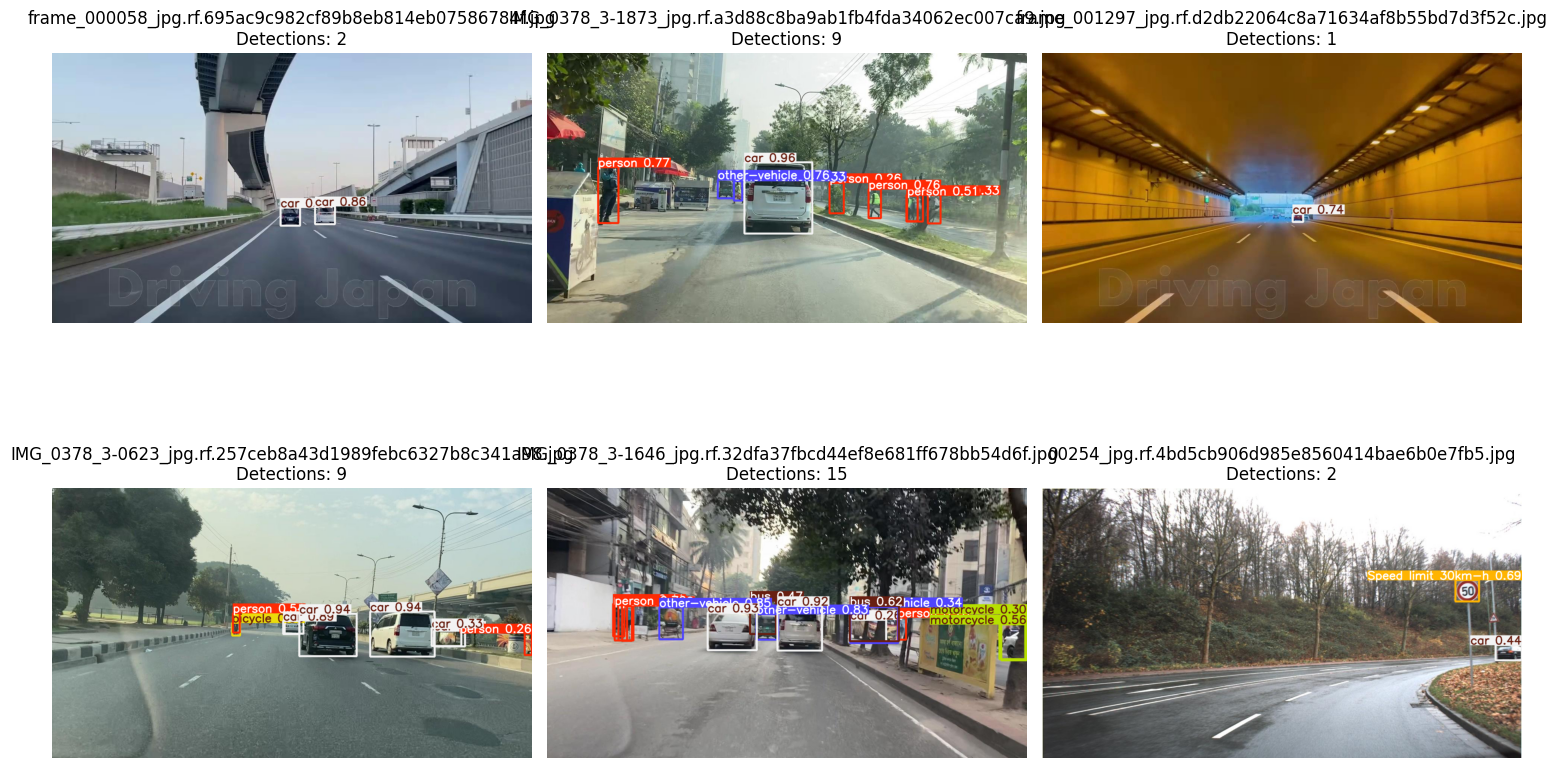


=== Detection Statistics ===
Total images processed: 671
Total detections: 4222

Detections per class:
  car: 2196
  other-vehicle: 343
  person: 701
  bicycle: 84
  bus: 338
  motorcycle: 254
  Speed limit 30km-h: 11
  Speed limit 50km-h: 9
  truck: 217
  Speed limit 70km-h: 6
  Speed limit 80km-h: 38
  Speed limit 40km-h: 7
  traffic light: 13
  Speed limit 100km-h: 3
  Speed limit 120km-h: 2


In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Define test images directory
test_dir = Path('dataset/test/images')
if not test_dir.exists():
    print(f"Test directory {test_dir} not found!")
    exit()

# Get all image files
image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    image_files.extend(list(test_dir.glob(ext)))

# Select up to 6 images for visualization
n_images_to_show = min(6, len(image_files))
selected_images = image_files[:n_images_to_show]

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Process each selected image
for idx, img_path in enumerate(selected_images):
    # Read and process image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run inference with batch=1
    results = model.predict(source=img, batch=1, verbose=False)
    result = results[0]

    # Draw boxes on the image
    annotated_img = result.plot()

    # Display image
    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f'{img_path.name}\nDetections: {len(result.boxes)}')
    axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(selected_images), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# === Detection Statistics for all test images ===
print("\n=== Detection Statistics ===")
total_detections = 0
class_counts = {}

for img_path in image_files:
    results = model.predict(source=str(img_path), batch=1, verbose=False)
    result = results[0]

    for box in result.boxes:
        cls = int(box.cls[0].item())  # get class index
        cls_name = model.names.get(cls, f'class_{cls}')
        class_counts[cls_name] = class_counts.get(cls_name, 0) + 1
        total_detections += 1

print(f"Total images processed: {len(image_files)}")
print(f"Total detections: {total_detections}\n")

print("Detections per class:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")


## Copy Training Results to Save Server

This section demonstrates how to securely copy the `runs` directory containing training results to a remote save server. This ensures that your experiment outputs are backed up and accessible for further analysis or sharing.

In [12]:
!pip install -q gdown
!gdown 'https://drive.google.com/uc?id=1nQ0_w3uG8McFgPxt-kVS1RPW1aKpb2YS'
!chmod 400 /kaggle/working/gcp-key
!ssh -i /kaggle/working/gcp-key -o StrictHostKeyChecking=no trung@34.142.148.134 "rm -rf /home/trung/runs"
!scp -i /kaggle/working/gcp-key -o StrictHostKeyChecking=no -r runs trung@34.142.148.134:/home/trung/
!echo "Done!"

Downloading...
From: https://drive.google.com/uc?id=1nQ0_w3uG8McFgPxt-kVS1RPW1aKpb2YS
To: /kaggle/working/gcp-key
100%|██████████████████████████████████████| 1.82k/1.82k [00:00<00:00, 7.83MB/s]
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
confusion_matrix.png                          100%  361KB 335.2KB/s   00:01    
val_batch1_labels.jpg                         100%  302KB 699.0KB/s   00:00    
val_batch0_labels.jpg                         100%  351KB   1.6MB/s   00:00    
val_batch0_pred.jpg                           100%  361KB   1.6MB/s   00:00    
val_batch1_pred.jpg                           100%  317KB   1.4MB/s   00:00    
val_batch2_labels.jpg                         100%  379KB   1.7MB/s   00:00    
val_batch2_pred.jpg                           100%  374KB   1.7MB/s   00:00    
R_curve.png                                   100%  463KB   2.0MB/s   00:00    
confusion_matrix_normalized

In [13]:
!zip -r runs.zip runs

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train2/ (stored 0%)
  adding: runs/detect/train2/confusion_matrix.png (deflated 17%)
  adding: runs/detect/train2/val_batch1_labels.jpg (deflated 11%)
  adding: runs/detect/train2/val_batch0_labels.jpg (deflated 9%)
  adding: runs/detect/train2/val_batch0_pred.jpg (deflated 9%)
  adding: runs/detect/train2/val_batch1_pred.jpg (deflated 10%)
  adding: runs/detect/train2/val_batch2_labels.jpg (deflated 9%)
  adding: runs/detect/train2/val_batch2_pred.jpg (deflated 9%)
  adding: runs/detect/train2/R_curve.png (deflated 4%)
  adding: runs/detect/train2/confusion_matrix_normalized.png (deflated 13%)
  adding: runs/detect/train2/F1_curve.png (deflated 3%)
  adding: runs/detect/train2/PR_curve.png (deflated 6%)
  adding: runs/detect/train2/P_curve.png (deflated 3%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/confusion_matrix.png (deflated 17%)
  adding: runs/detect/train/val_batch1_la